Using 'DeepFashion' Dataset for Test Purposes: (Category and Attribute Prediction Benchmark)

- https://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html


DISC2021 Image Similarity Dataset:
- https://sites.google.com/view/isc2021/dataset

**Given a picture, find most similar 3 pictures from the set**

**Techs used:**

**CLIP** for Embeddings

Vectors stored on memory, no vectordb implemented on this yet.

*1- Load and Preprocess Images*

In [29]:
import boto3
import json
import base64
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

image_dir = "test_images_design_subset"

# Load and preprocess images
def load_images(image_dir):
    image_list = []
    file_names = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(image_dir, filename)
            with open(img_path, "rb") as img_file:
                img_data = img_file.read()
                image_list.append(img_data)
            file_names.append(img_path)
    return image_list, file_names

image_data_list, file_names = load_images(image_dir)

# Display number of loaded images
print(f"Loaded {len(image_data_list)} images.")

Loaded 784 images.


*AWS Config*

In [30]:
import json
import boto3
import base64

boto3_session = boto3.session.Session(region_name="us-east-1", profile_name="aihubdev")
bedrock_runtime = boto3_session.client(service_name='bedrock-runtime')

model_id = "amazon.titan-embed-image-v1"

accept = "application/json"
content_type = "application/json"

Function to get image embedding using Titan

In [31]:
# Function to get image embedding using Titan model
def get_image_embedding_titan(image_data, model_id, accept, content_type, output_embedding_length):
    try:
        input_image = base64.b64encode(image_data).decode('utf8')
        body = json.dumps({
            "inputImage": input_image,
            "embeddingConfig": {
                "outputEmbeddingLength": output_embedding_length
            }
        })
        response = bedrock_runtime.invoke_model(
            body=body, modelId=model_id, accept=accept, contentType=content_type
        )
        response_body = json.loads(response['body'].read().decode('utf8'))
        embedding = response_body['embedding']
        return embedding
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

Function to get text embedding from Titan

In [32]:
# Function to get text embedding using Titan model
def get_text_embedding_titan(input_text, model_id, accept, content_type, output_embedding_length):
    try:
        body = json.dumps({
            "inputText": input_text,
            "embeddingConfig": {
                "outputEmbeddingLength": output_embedding_length
            }
        })
        response = bedrock_runtime.invoke_model(
            body=body, modelId=model_id, accept=accept, contentType=content_type
        )
        response_body = json.loads(response['body'].read().decode('utf8'))
        embedding = response_body['embedding']
        return embedding
    except Exception as e:
        print(f"Error processing text: {e}")
        return None

*2- Extract embeddings using Titan*

In [33]:
# Get embeddings for all images
output_embedding_length = 256
embeddings = []
img_len = len(image_data_list)
count = 1
for img_data in image_data_list:
    embedding = get_image_embedding_titan(img_data, model_id, accept, content_type, output_embedding_length)
    if embedding is not None:
        embeddings.append(embedding)
        if(count%20 == 0):
            print("Generated: ", count)
    count+=1

# Convert embeddings to numpy array
embeddings_array = np.array(embeddings)

# Display number of generated embeddings
print(f"Generated {len(embeddings_array)} embeddings.")

Generated:  20
Generated:  40
Generated:  60
Generated:  80
Generated:  100
Generated:  120
Generated:  140
Generated:  160
Generated:  180
Generated:  200
Generated:  220
Generated:  240
Generated:  260
Generated:  280
Generated:  300
Generated:  320
Generated:  340
Generated:  360
Generated:  380
Generated:  400
Generated:  420
Generated:  440
Generated:  460
Generated:  480
Generated:  500
Generated:  520
Generated:  540
Generated:  560
Generated:  580
Generated:  600
Generated:  620
Generated:  640
Generated:  660
Generated:  680
Generated:  700
Generated:  720
Generated:  740
Generated:  760
Generated:  780
Generated 784 embeddings.


*3- Find most Similar images among the image file with the Given Image*

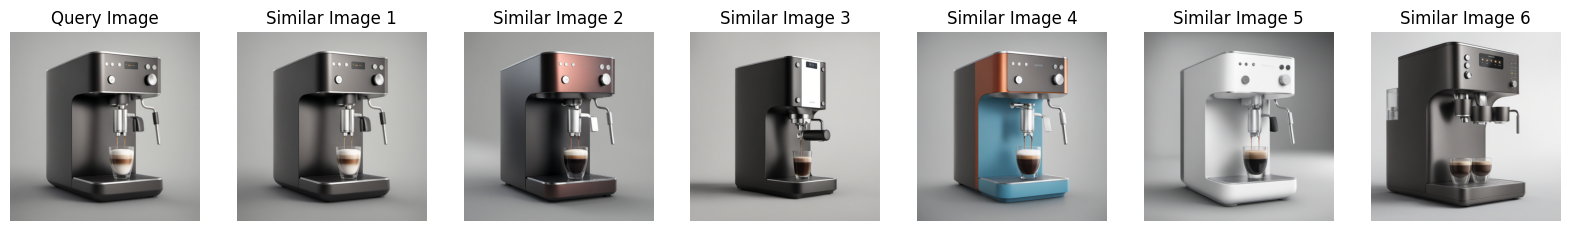

In [41]:
# Function to find the most similar images
def find_most_similar_images(img_path, embeddings, file_names, top_k):
    # Get the embedding of the given image
    with open(img_path, "rb") as img_file:
        img_data = img_file.read()

    embedding = get_image_embedding_titan(img_data, model_id, accept, content_type, output_embedding_length)
    embedding = np.array(embedding).reshape(1, -1)  # Reshape to (1, -1) for single sample
    
    similarities = cosine_similarity(embedding, embeddings)
    top_k_indices = similarities.flatten().argsort()[-top_k:][::-1]
    
    # Display the most similar images
    fig, axes = plt.subplots(1, top_k + 1, figsize=(20, 5))
    
    # Display query image
    query_img = Image.open(img_path)
    axes[0].imshow(query_img)
    axes[0].set_title("Query Image")
    axes[0].axis("off")
    
    for i, idx in enumerate(top_k_indices):
        #similar_img_path = os.path.join('test_images_design_subset', file_names[idx])
        similar_img = Image.open(file_names[idx])
        axes[i + 1].imshow(similar_img)
        axes[i + 1].set_title(f"Similar Image {i+1}")
        axes[i + 1].axis("off")
    
    plt.show()

# Path to the query image
query_image_path = 'test_images/design_test3.png'

# Find and display the most similar images
find_most_similar_images(query_image_path, embeddings_array, file_names, top_k=6)

*4- Find most Similar images among the image file with the Given Text*

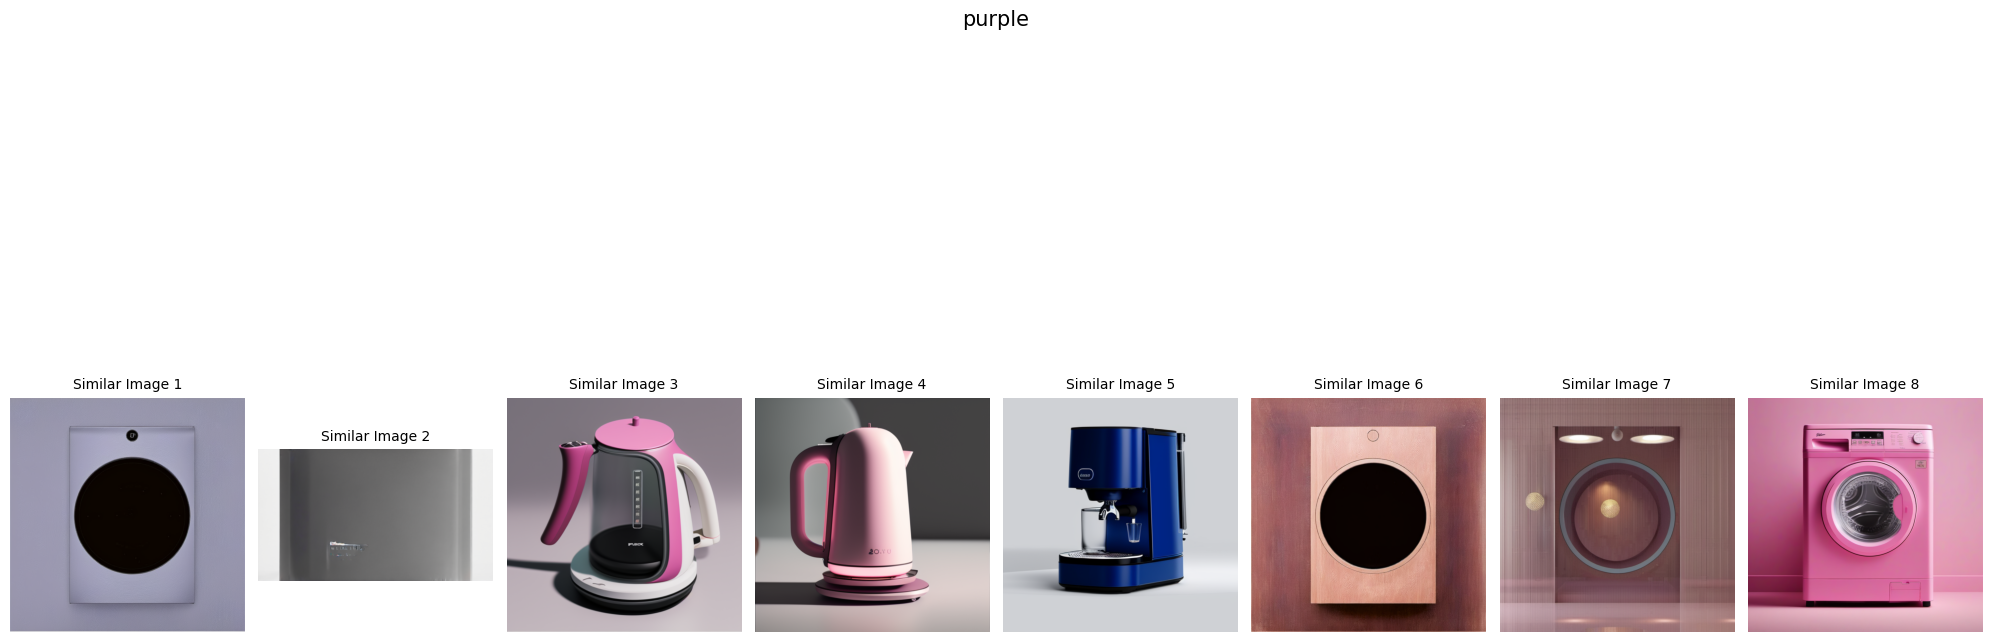

In [54]:
# Function to find the most similar images with text
def find_most_similar_images(query_text, embeddings, file_names, top_k):
    embedding = get_text_embedding_titan(query_text, model_id, accept, content_type, output_embedding_length)
    embedding = np.array(embedding).reshape(1, -1)  # Reshape to (1, -1) for single sample
    
    similarities = cosine_similarity(embedding, embeddings)
    top_k_indices = similarities.flatten().argsort()[-top_k:][::-1]
    
    # Display the most similar images
    fig, axes = plt.subplots(1, top_k, figsize=(20, 10))  # Adjust figure size as needed
    
    # Display query text off the axes
    fig.suptitle(query_text, fontsize=15, ha='center')  # Set smaller font size and center text
    
    for i, idx in enumerate(top_k_indices):
        similar_img = Image.open(file_names[idx])
        axes[i].imshow(similar_img)
        axes[i].set_title(f"Similar Image {i+1}", fontsize=10)  # Set font size for image titles
        axes[i].axis("off")
    
    plt.tight_layout(pad=1)  # Adjust padding to minimize white space
    plt.subplots_adjust(top=0.85, bottom=0.1)  # Adjust top and bottom to fit the suptitle and images
    plt.show()

# Example query text
#query_text = 'lora_washing_machine-000006_1,2_ washing-machine, product, _lora_SDXL_Black_Sa_May_0,5_, Ultra realistic detailed photography'
query_text = 'purple'

# Find and display the most similar images
find_most_similar_images(query_text, embeddings_array, file_names, top_k=8)

*4- Find most Similar images among the image file with the Given Text, with Positive and Negative Prompts*

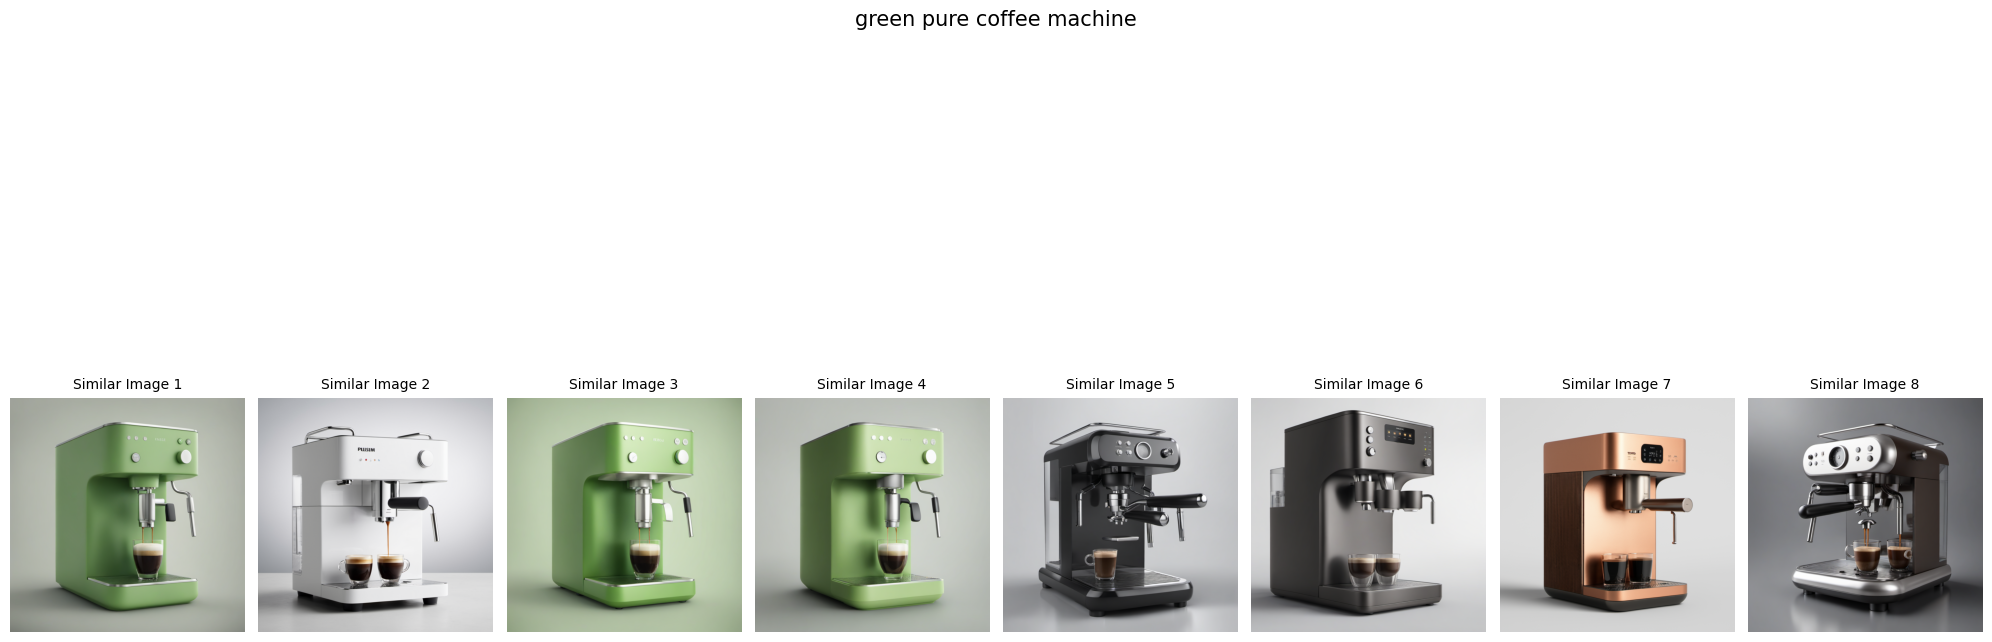

In [53]:
# Function to find the most similar images with text
def find_most_similar_images(query_text_positive, query_text_negative, embeddings, file_names, top_k):
    embedding_positive = get_text_embedding_titan(query_text_positive, model_id, accept, content_type, output_embedding_length)
    embedding_positive = np.array(embedding_positive).reshape(1, -1)  # Reshape to (1, -1) for single sample

    embedding_negative = get_text_embedding_titan(query_text_negative, model_id, accept, content_type, output_embedding_length)
    embedding_negative = np.array(embedding_negative).reshape(1, -1)  # Reshape to (1, -1) for single sample

    # Combine positive and negative embeddings
    embedding = embedding_positive - embedding_negative
    
    similarities = cosine_similarity(embedding, embeddings)
    top_k_indices = similarities.flatten().argsort()[-top_k:][::-1]
    
    # Display the most similar images
    fig, axes = plt.subplots(1, top_k, figsize=(20, 10))  # Adjust figure size as needed
    
    # Display query text off the axes
    fig.suptitle(query_text, fontsize=15, ha='center')  # Set smaller font size and center text
    
    for i, idx in enumerate(top_k_indices):
        similar_img = Image.open(file_names[idx])
        axes[i].imshow(similar_img)
        axes[i].set_title(f"Similar Image {i+1}", fontsize=10)  # Set font size for image titles
        axes[i].axis("off")
    
    plt.tight_layout(pad=1)  # Adjust padding to minimize white space
    plt.subplots_adjust(top=0.85, bottom=0.1)  # Adjust top and bottom to fit the suptitle and images
    plt.show()

# Example query text
#query_text = 'lora_washing_machine-000006_1,2_ washing-machine, product, _lora_SDXL_Black_Sa_May_0,5_, Ultra realistic detailed photography'
query_text_positive = 'green pure coffee machine'
query_text_negative = 'brown, blue, red, yellow, white, black, gray, washing machine'

# Find and display the most similar images
find_most_similar_images(query_text_positive, query_text_negative, embeddings_array, file_names, top_k=8)